In [2]:
import numpy as np
import csv
import pandas as pd

In [3]:
variable_names = 'Trial,Stimulus 1 value, Stimulus 1 std, Stimulus 2 value, Stimulus 2 std'
variable_names = variable_names.split(',')
print(variable_names)

['Trial', 'Stimulus 1 value', ' Stimulus 1 std', ' Stimulus 2 value', ' Stimulus 2 std']


In [3]:

stimulus_1_std = np.linspace(0, 2, 10)
stimulus_2_std = 0.1
stimulus_1_mean = np.linspace(-3, 3, 100)
stimulus_2_mean = np.linspace(-1, 1, 20)
trial_number = 1000
# write to experiment_stim_pairs.csv
import csv
with open('experiment_stim_pairs.csv', mode='w') as f:
    writer = csv.writer(f)
    writer.writerow(variable_names)
    for d, s2_mean in enumerate(stimulus_2_mean):
        for i, s1_std in enumerate(stimulus_1_std):
            for j, s1_mean in enumerate(stimulus_1_mean):
                for tn in range(trial_number):
                    writer.writerow([(d+1)*(i+1)*(j+1)*(tn+1), s1_mean, s1_std, s2_mean, stimulus_2_std])

In [4]:
results = pd.read_csv('experiment_results.csv')
results.describe()

,Trial,Stimulus 1 Value,Stimulus 1 Std,Stimulus 2 Value,Stimulus 2 Std
count,90.000000,90.0,90.0,90.000000,90.0
mean,45.500000,0.0,0.0,0.000000,0.5
std,26.124701,0.0,0.0,2.596454,0.0
min,1.000000,0.0,0.0,-4.000000,0.5
25%,23.250000,0.0,0.0,-2.000000,0.5
50%,45.500000,0.0,0.0,0.000000,0.5
75%,67.750000,0.0,0.0,2.000000,0.5
max,90.000000,0.0,0.0,4.000000,0.5


In [133]:
def get_prob_from_one_value_pair(results, std, mean):
    mean_results = results[results['Stimulus 1 Value'] == mean]
    std_results = mean_results[mean_results['Stimulus 1 Std'] == std]
    decision = std_results['Comparison Result']
    return np.sum(decision)/trial_number


In [134]:
means = results['Stimulus 1 Value'].unique()
stds = results['Stimulus 1 Std'].unique()
stimulus_2_mean = results['Stimulus 2 Value'].unique()
decision_prob = np.zeros((len(means), len(stds), len(stimulus_2_mean)))
for k, s2_mean in enumerate(stimulus_2_mean):
    for i, mean in enumerate(means):
        for j, std in enumerate(stds):
            decision_prob[i, j, k] = get_prob_from_one_value_pair(results[results['Stimulus 2 Value']==s2_mean], std, mean)

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
discrete_palette = sns.color_palette("crest", n_colors=10)

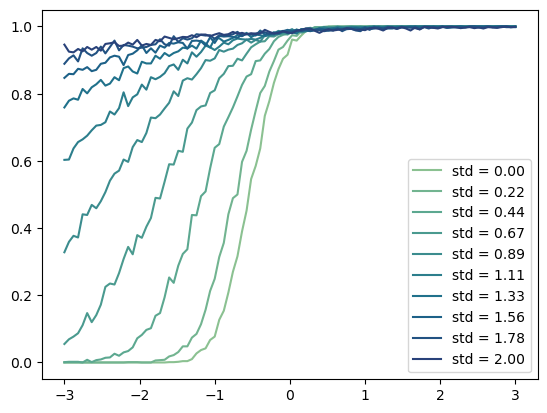

In [136]:
for i in range(len(stds)):
    sns.lineplot(x=means, y=decision_prob[:, i, 4], label=f'std = {stds[i]:.2f}', color=discrete_palette[i])
plt.legend()
plt.show()

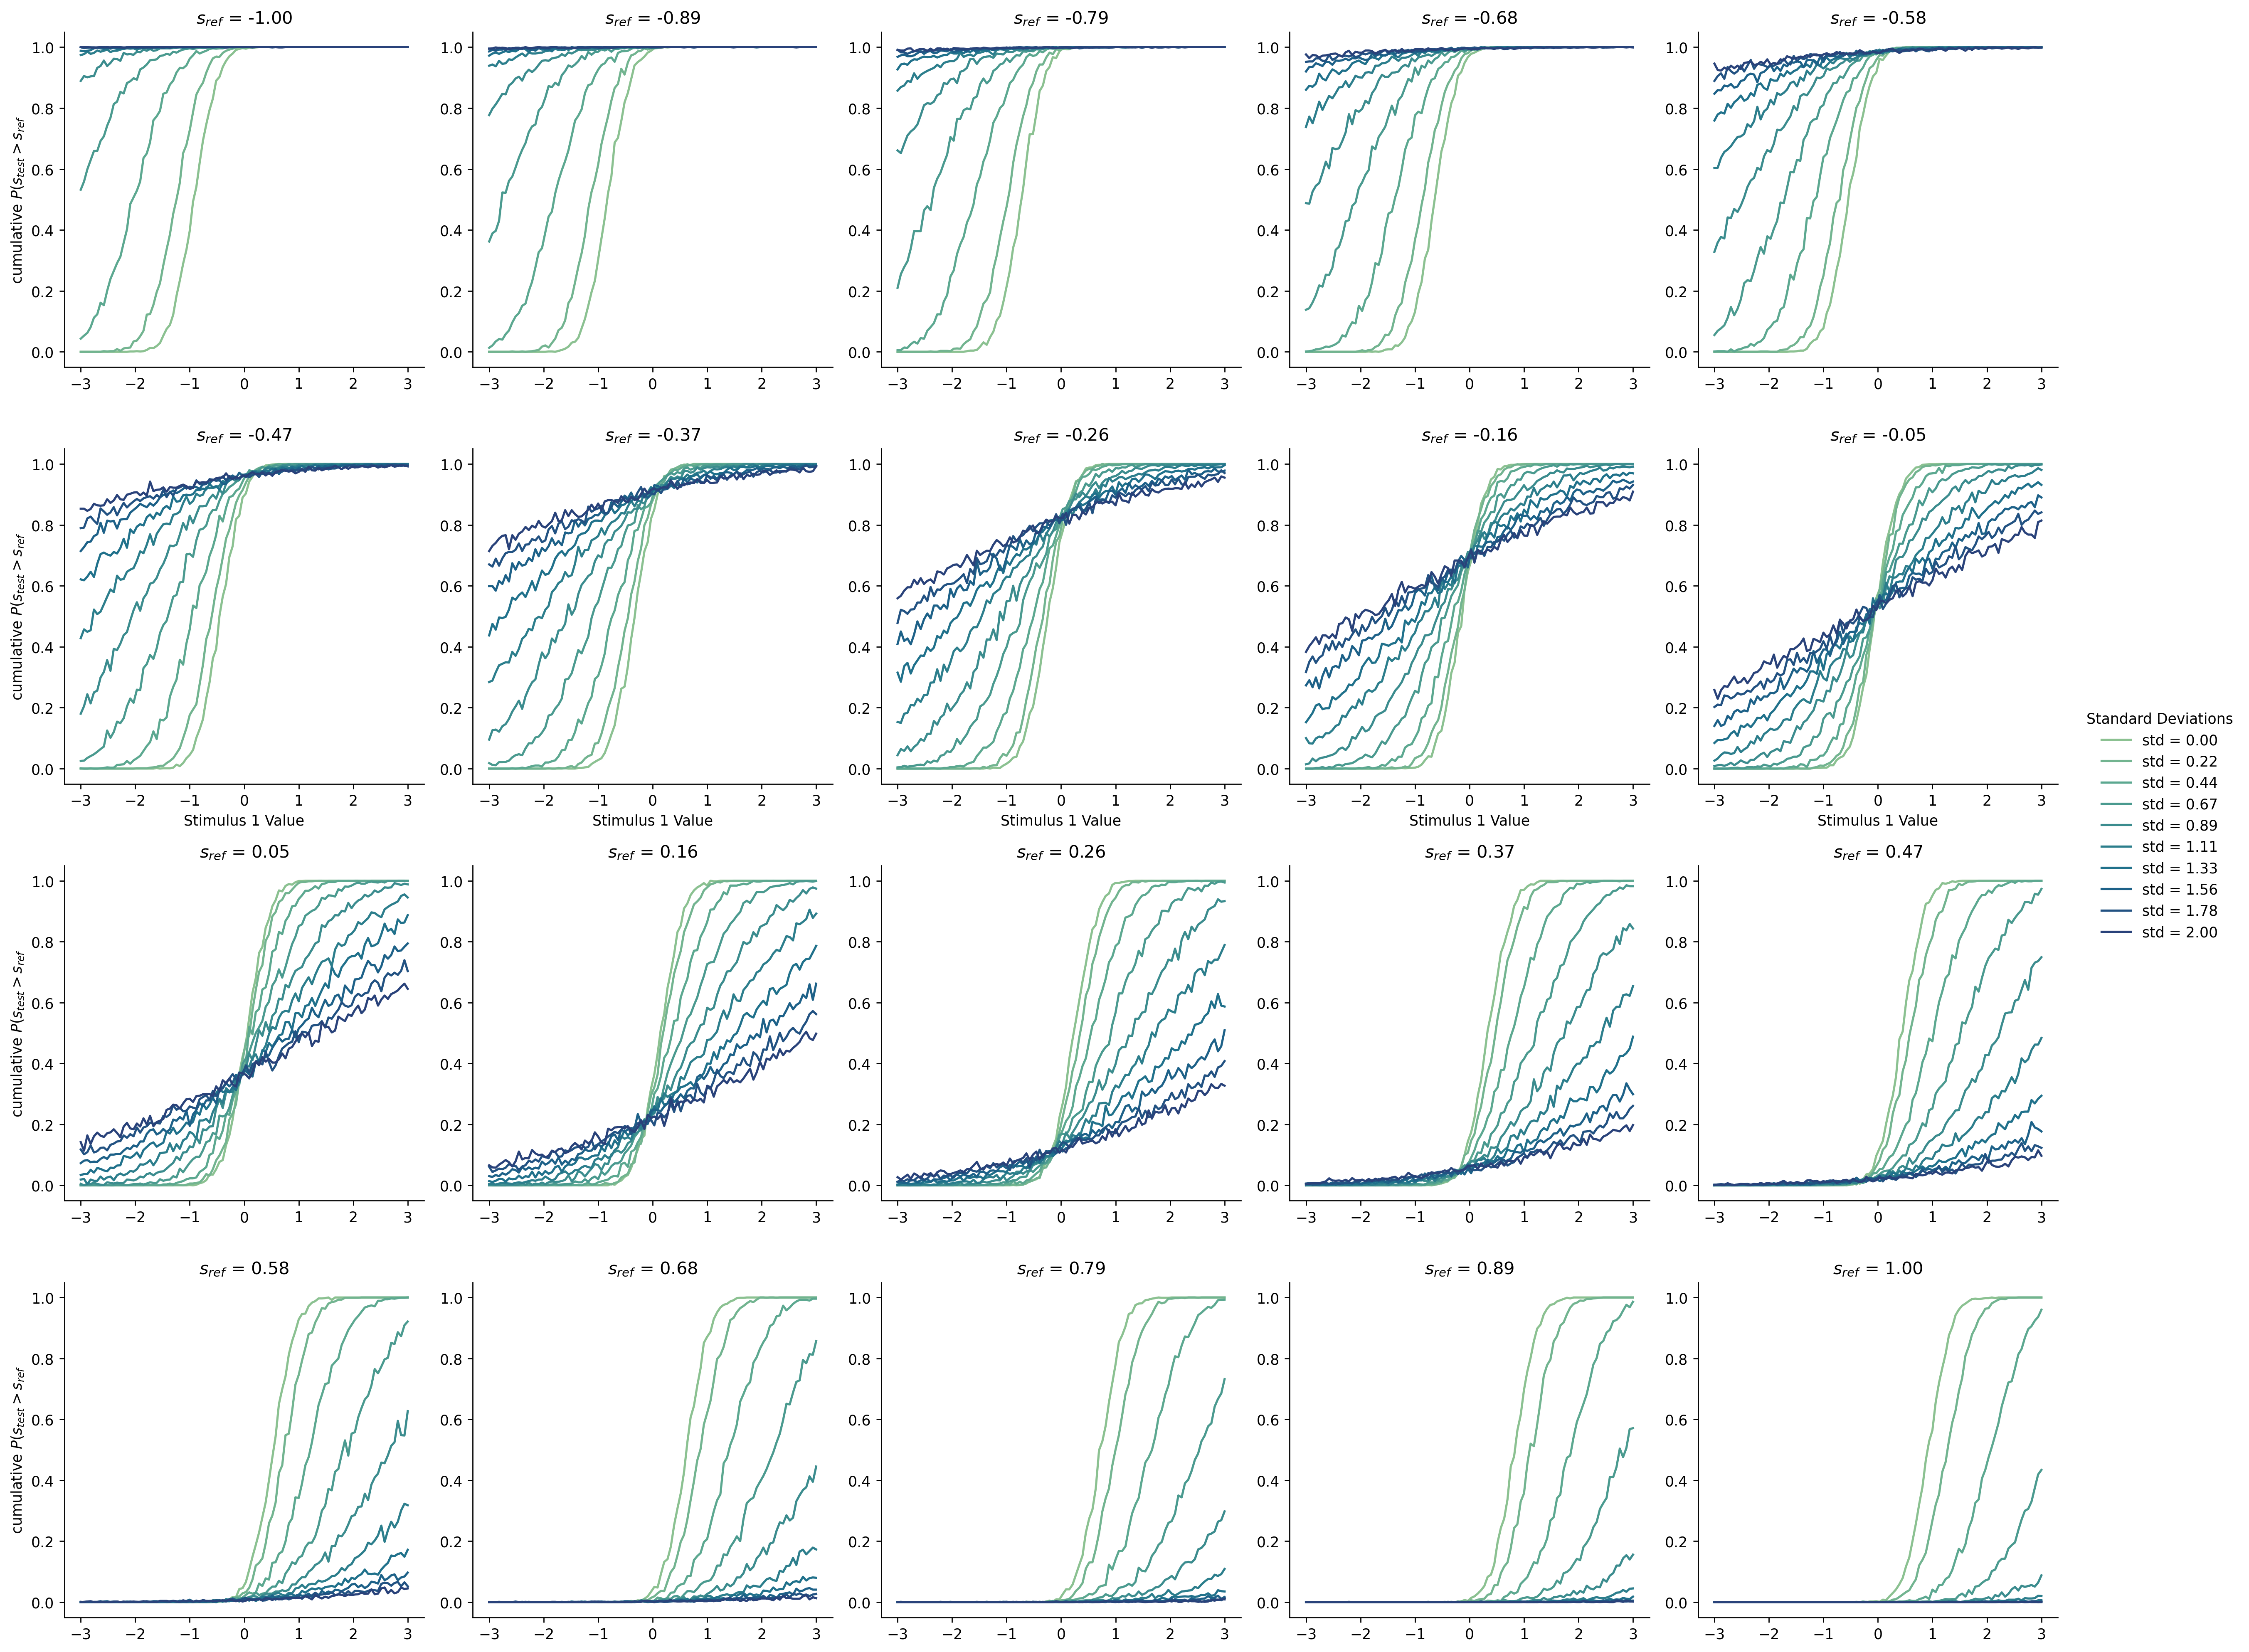

In [137]:
figure, axes = plt.subplots(4, 5, figsize=(20, 16), dpi=250)
for j in range(len(stimulus_2_mean)):
    for i in range(len(stds)):
        sns.lineplot(x=means, y=decision_prob[:, i, j], label=f'std = {stds[i]:.2f}', ax=axes[j//5, j%5], color=discrete_palette[i], legend=False)
        axes[j//5, j%5].set_title(f'$s_{{ref}}$ = {stimulus_2_mean[j]:.2f}')


handles, labels = axes[j//5, j%5].get_legend_handles_labels()
figure.legend(handles, labels, title='Standard Deviations', loc='center left',
              bbox_to_anchor=(1, 0.5), bbox_transform=figure.transFigure, 
              frameon=False)

# Set shared x and y labels
for j, ax in enumerate(axes.flat):
    # Set xlabel only on the bottom row
    if j // 5 == 1:  # Check if it's in the bottom row
        ax.set_xlabel("Stimulus 1 Value")  # Replace with your desired xlabel
    
    # Set ylabel only on the leftmost column
    if j % 5 == 0:  # Check if it's in the first column
        ax.set_ylabel("cumulative $P(s_{test} > s_{ref}$")  # Replace with your desired ylabel

# Adjust layout to make room for the legend and shared labels

plt.tight_layout()
sns.despine()       
  

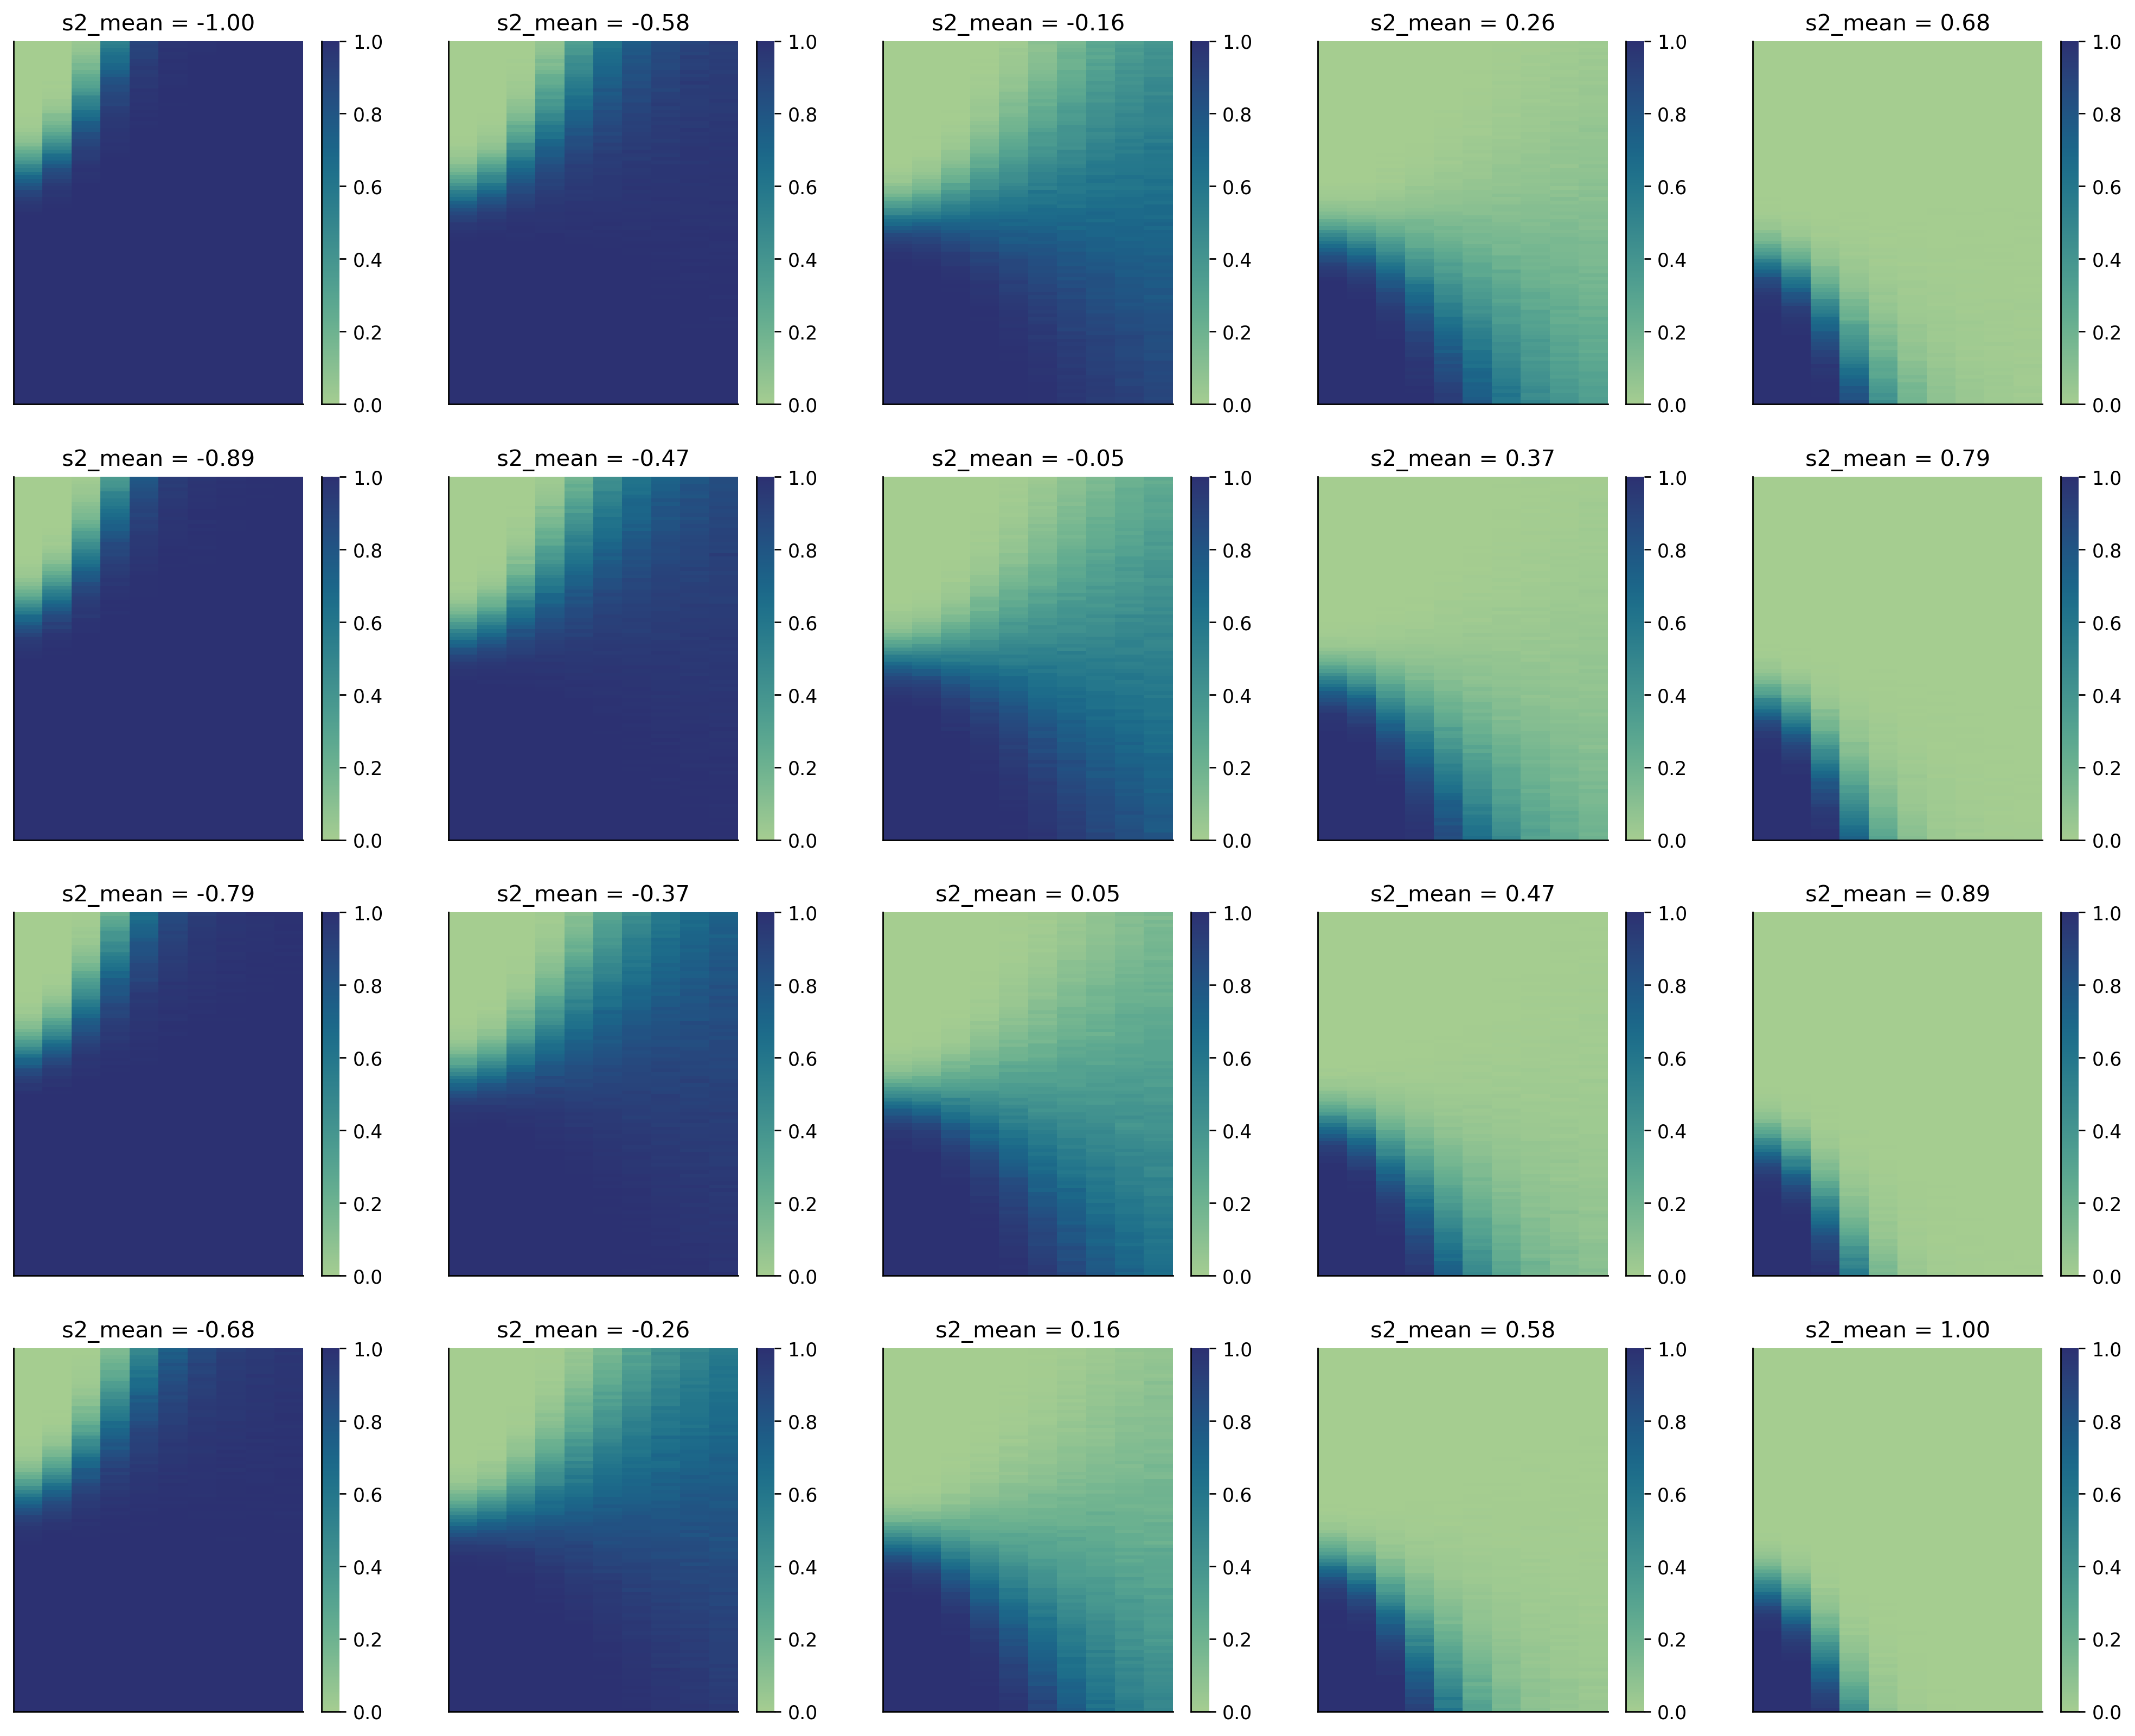

In [ ]:
figure, axes = plt.subplots(4, 5, figsize=(20, 16), dpi=250)
for j in range(len(stimulus_2_mean)):
    sns.heatmap(data=decision_prob[:, :, j], ax=axes[j % 4][j // 4], cmap='crest', xticklabels='', yticklabels='')
    axes[j%4, j//4].set_title(f's2_mean = {stimulus_2_mean[j]:.2f}')
    sns.despine()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

In [143]:
def fit_sigmoid(means, decision_prob, idx, s_ref_idx, maxfev=800):   
    # Fit the sigmoid function to the data using curve_fit
    popt, pcov = curve_fit(sigmoid, means, decision_prob[:, idx, s_ref_idx], p0=[1, 1, 0], maxfev=maxfev)
    # Extract the optimal parameters
    L_fit, k_fit, x0_fit = popt
    return L_fit, k_fit, x0_fit

In [152]:
discrete_palette = sns.color_palette("crest", n_colors=decision_prob.shape[2])

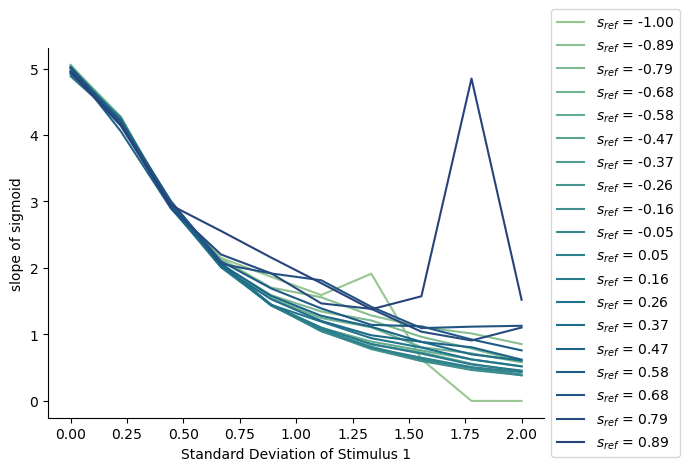

In [153]:
fitted_k = np.zeros(decision_prob.shape[1])
for j in range(decision_prob.shape[2]-1):
    for i in range(decision_prob.shape[1]):
        L_fit, k_fit, x0_fit = fit_sigmoid(means, decision_prob, i, j, maxfev=100000)
        # print(f'L_fit = {L_fit}, k_fit = {k_fit}, x0_fit = {x0_fit}')
        fitted_k[i] = k_fit

    sns.lineplot(x=stds, y=fitted_k, label = f'$s_{{ref}}$ = {stimulus_2_mean[j]:.2f}', color=discrete_palette[j])
    plt.xlabel('Standard Deviation of Stimulus 1')
    plt.ylabel('slope of sigmoid')
    sns.despine()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
